In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cygnus_lib as cy
import mylib as my
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
import os
import requests
import ROOT
import root_numpy as rtnp
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.22/06


In [2]:
f=ROOT.TFile.Open('https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LAB/histograms_Run04037.root')
print ('Find Keys: '+str(len(f.GetListOfKeys())))

Find Keys: 100


In [3]:
# LIME
phKev         = 6000/5.9
pixelscale    = 0.150 
run           = 3957
run_ped       = 3965 
cimax         = 300
cimin         = 0 
tag = 'LAB'
rescale       = 512
nsigma        = 1.5

print ('Open file: '+cy.swift_root_file(tag, run))
f = ROOT.TFile.Open(cy.swift_root_file(tag, run))
print ('Find Keys: '+str(len(f.GetListOfKeys())))
pic, wfm = cy.root_TH2_name(f)
max_image = len(pic)
max_wfm = len(wfm)
print ("# of Images (TH2) Files: {:d}".format(max_image))
print ("# of Waveform (TH2) Files: {:d} ".format(max_wfm))
image = rtnp.hist2array(f.Get(pic[0])).T
x_resolution = image.shape[1]
y_resolution = image.shape[0]
print ('Camera X, Y pixel: {:d} {:d} '.format(x_resolution, y_resolution))
xyscale = x_resolution/rescale
rescale_pixelscale = xyscale*pixelscale
print("Scale: %d Pixel/Mpixel, %.2f [mm/Mpixel]" % (xyscale, rescale_pixelscale))

Open file: https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LAB/histograms_Run03957.root
Find Keys: 100
# of Images (TH2) Files: 100
# of Waveform (TH2) Files: 0 
Camera X, Y pixel: 2048 2048 
Scale: 4 Pixel/Mpixel, 0.60 [mm/Mpixel]


In [4]:
def ped_(run, path='./', tag = 'LAB', min_image_to_read = 0, max_image_to_read = 0):
    #
    # run numero del run
    # path path lettura/scrittura piedistalli
    # tag subdirectory dei dati
    # min_image_to_read , max_image_to_read  range di imagine sul quale fare i piedistalli 
    # max_image_to_read = 0 EQUIVALE A TUTTE LE IMMAGINI
    #
    import ROOT
    import root_numpy as rtnp
    import numpy as np
    import cygnus_lib as cy
    # funzione per fare i piedistalli se gia' non esistino nella diretory
    fileoutm = (path+"run%d_mean.h5" % (run))
    fileouts = (path+"run%d_sigma.h5" % (run))
    try: 
        # i file gia' esistono
        m_image = cy.read_image_h5(fileoutm)
        s_image = cy.read_image_h5(fileouts)
        return m_image, s_image
    except:
        # i file non esistono crea il file delle medie e delle sigma per ogni pixel dell'immagine
        print (">>> Pedestal Maker! <<<")
        try:
            
            print ('Open file: '+cy.swift_root_file(tag, run))
            f=ROOT.TFile.Open(cy.swift_root_file(tag, run))
            print ('Find Keys: '+str(len(f.GetListOfKeys())))
            pic, wfm = cy.root_TH2_name(f)
            max_image = len(pic)
            max_wfm = len(wfm)
            image = rtnp.hist2array(f.Get(pic[0])).T
            x_resolution = image.shape[1]
            y_resolution = image.shape[0]
            print ("# of Images (TH2) Files: %d " % (max_image))
            print ("# of Waveform (TH2) Files: %d " % (max_wfm))

        except:
            print ("ERROR: No file %d" % (run))
            return
        if max_image_to_read == 0:
            max_image_to_read=max_image 
        print ("WARNING: pdestal from %d to %d" % (min_image_to_read, max_image_to_read))

        m_image = np.zeros((x_resolution, y_resolution), dtype=np.float64)
        s_image = np.zeros((x_resolution, y_resolution), dtype=np.float64)

        n0 = 0
        for iTr in range(min_image_to_read, max_image_to_read):
            image = rtnp.hist2array(f.Get(pic[iTr])).T
            m_image += image
            s_image += image**2 
            if n0 > 0 and n0 % 10==0:  # print progress and debung info for poit 200, 200...
                print ("Debug Image[200,200]: %d => %.2f %.2f %.2f " % (iTr,
                                                image[200,200],
                                                np.sqrt((s_image[200,200] - 
                                                        m_image[200,200]**2 
                                                          / (n0+1)) / n0),
                                                m_image[200,200]/(n0+1),
                                                ))
            n0 += 1
        m_image = m_image/n0
        s_image = np.sqrt((s_image - m_image**2 * n0) / (n0 - 1))

        ###### print Info and Save OutPut ######################################

        print ("sigma %f" % (s_image[200,200]))
        cy.write_image_h5(fileoutm, m_image)
        cy.write_image_h5(fileouts, s_image)
        print("DONE OUTPUT on files: %s, %s", (fileoutm, fileouts))
        return m_image, s_image

############

m_image, s_image = ped_(run_ped)

#########################
#s_image = s_image[~np.isnan(s_image)]
th_image   = np.round(m_image + nsigma*s_image)
print ("light over Th: %.2f " % (th_image.sum()-m_image.sum()))

light over Th: nan 


In [10]:
print(len(s_image))
print(len(s_image[np.isnan(s_image)]))
s_image[np.isnan(s_image)]

2048
208


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


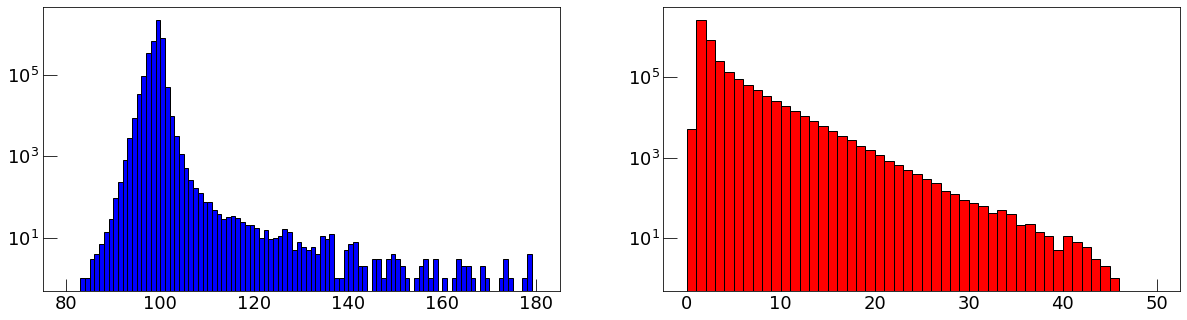

In [6]:
cy.set_atlas_style('long')
fig, ax = plt.subplots(1,2)
ax[0].hist(m_image.ravel(), bins=100, range=(80, 180), fc='b', ec='k')
ax[1].hist(s_image.ravel(), bins=50, range=(0.0, 50.0), fc='r', ec='k')
ax[0].set_yscale("log")
ax[1].set_yscale("log")
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


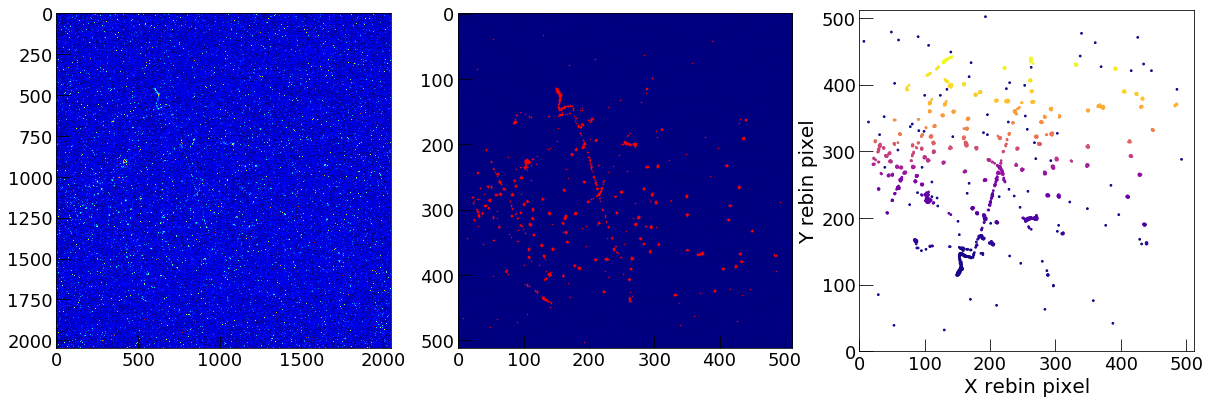

/s3/mazzitel/cygnus_lib.py:401: RuntimeWarning: invalid value encountered in double_scalars
  pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])


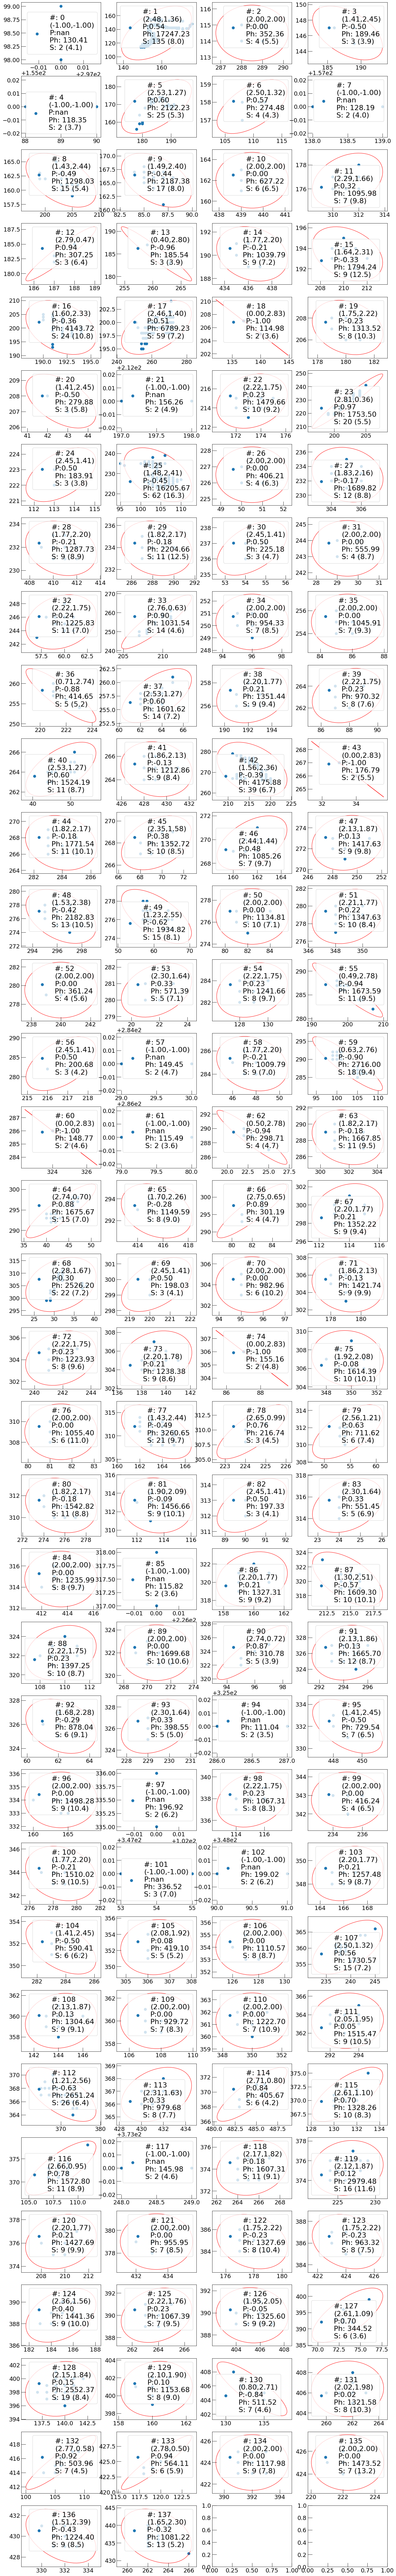

In [17]:
cy.set_atlas_style('square')
from matplotlib import patches
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
#####################################################
# show immage
iTr             = 3
image           = rtnp.hist2array(f.Get(pic[iTr])).T 
fig, ax        = plt.subplots(1,3, figsize=(20, 6))
ax[0].imshow(image, vmin=95,vmax=150, cmap='jet')

rebin_image     = cy.rebin((image-m_image), (rescale, rescale))
rebin_th_image  = cy.rebin((th_image-m_image), (rescale, rescale))
ax[1].imshow(rebin_image, vmin=0, vmax=150, cmap='jet')
edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
points          = np.array(np.nonzero(edges)).T.astype(float) 
ax[1].plot(points[:,1], points[:,0], 'r.', markersize=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(points)

dbscan = DBSCAN(eps=0.05, min_samples = 2) # eps=0.1
dbscan.fit(points)

clusters = dbscan.fit_predict(X_scaled)
ax[2].scatter(points[:,1], points[:,0], s=3, c=dbscan.labels_, cmap="plasma")
ax[2].set_xlabel("X rebin pixel")
ax[2].set_ylabel("Y rebin pixel")
ax[2].set_xlim(0,rebin_image.shape[0])
ax[2].set_ylim(0,rebin_image.shape[1])
plt.show()

for i in range (min(dbscan.labels_), max(dbscan.labels_)):
    ph = 0
    for j in range(0, len(points[:,1][dbscan.labels_==i])):
        ph += (rebin_image[int(points[j,1]), int(points[j,0])])


n_cluster = max(dbscan.labels_)
h_plot    = 4
l_plot    = math.ceil(n_cluster/h_plot)
fig, ax   = plt.subplots(l_plot, h_plot , figsize=(20, l_plot*4))
h_plot_i  = 0
l_plot_i  = 0

for ic in range(0, n_cluster):
    yc = points[:,1][dbscan.labels_==ic]
    xc = points[:,0][dbscan.labels_==ic]

    el_plt, el_par = cy.confidence_ellipse(yc, xc, ax[l_plot_i, h_plot_i], edgecolor='red')
    ph, dim = cy.cluster_par(yc, xc, rebin_image)
    width, height, pearson = cy.confidence_ellipse_par(yc, xc)
    ax[l_plot_i, h_plot_i].scatter(yc, xc, 
                                   label = ('#: %d\n(%.2f,%.2f)\nP:%.2f\nPh: %.2f\nS: %d (%.1f)' %
                                    (ic, width, height, pearson, ph*xyscale*xyscale, dim, ph/dim)))

    ax[l_plot_i, h_plot_i].legend()
    if (h_plot_i==h_plot-1):
        h_plot_i = 0
        l_plot_i +=1
    else:
        h_plot_i +=1
plt.show()

2.2222222222222223 1.7497795275581802 0.23456790123456792
109.5 322.5 1.5 1.5 0.0


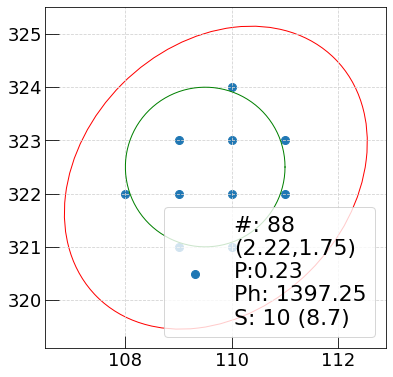

In [19]:
# show a single cluster
ic = 88
fig, ax = plt.subplots()

ph, dim = cy.cluster_par(points[:,1][dbscan.labels_==ic], points[:,0][dbscan.labels_==ic], rebin_image)
width, height, pearson = cy.confidence_ellipse_par(points[:,1][dbscan.labels_==ic], 
                                                points[:,0][dbscan.labels_==ic])
ax.scatter(points[:,1][dbscan.labels_==ic], points[:,0][dbscan.labels_==ic],
           label = ('#: %d\n(%.2f,%.2f)\nP:%.2f\nPh: %.2f\nS: %d (%.1f)' % 
                    (ic, width, height, pearson, ph*xyscale*xyscale, dim, ph/dim)))
#ax.scatter(points[:,1][dbscan.labels_==ic], points[:,0][dbscan.labels_==ic])
x0, y0, a, b, theta = cy.cluster_elips(points[dbscan.labels_==ic])
cy.confidence_ellipse(points[:,1][dbscan.labels_==ic], points[:,0][dbscan.labels_==ic], ax, edgecolor='red')
#width, height, pearson = confidence_ellipse_par(points[:,1][dbscan.labels_==ic], points[:,0][dbscan.labels_==ic])
print(width, height, pearson)
t = np.linspace(0, 2*np.pi, 100)
print (x0, y0, a, b, theta)
plt.plot(x0 + a*np.cos(t)*np.cos(theta) - b*np.sin(t)*np.sin(theta) , 
         y0 + b*np.sin(t)*np.cos(theta) + a*np.cos(t)*np.sin(theta), 'g-')
plt.grid(color='lightgray',linestyle='--')
plt.legend()
plt.show()

Numbero of immage: 100
Event:  0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


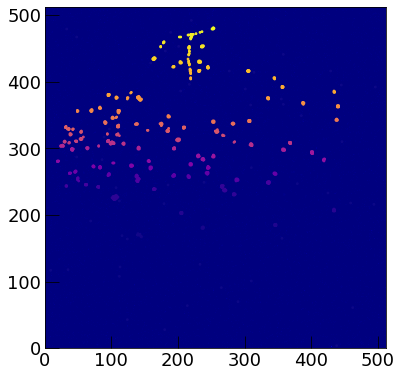

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launche

Event:  20


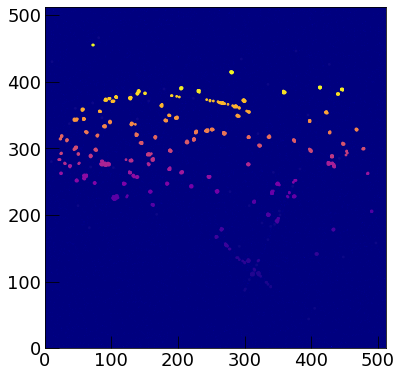

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launche

Event:  40


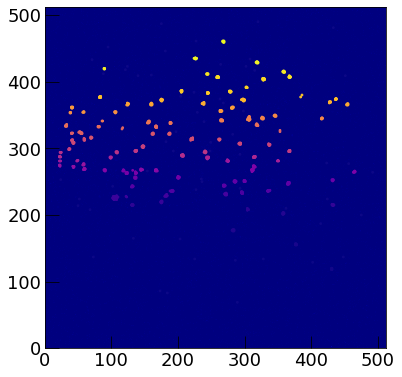

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launche

Event:  60


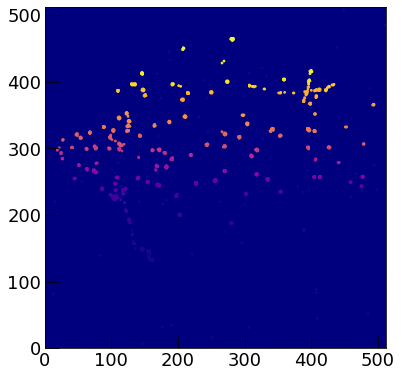

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launche

Event:  80


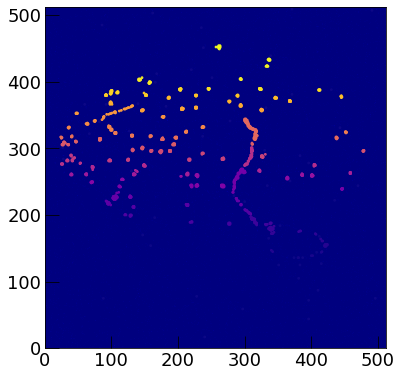

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launche

out file dbscan_run3957_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_100.txt


In [23]:
cy.set_atlas_style('square')
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

print ("Numbero of immage: %d"% max_image)

data_to_save = []
files = ("dbscan_run%d_cmin_%d_cmax_%d_rescale_%d_nsigma_%.1f_ev_%d.txt" % 
                 (run, cimin, cimax, rescale, nsigma, max_image))
for iTr in range(0, max_image):

    image = rtnp.hist2array(f.Get(pic[iTr])).T

    rebin_image     = cy.rebin(image-m_image, (rescale, rescale))  
    rebin_th_image  = cy.rebin((th_image-m_image), (rescale, rescale))

    edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
    points          = np.array(np.nonzero(edges)).T.astype(float) 
    scaler          = StandardScaler()
    X_scaled        = scaler.fit_transform(points)

    dbscan          = DBSCAN(eps=0.05, min_samples = 2)
    dbscan.fit(points)

    clusters = dbscan.fit_predict(X_scaled)

    for ic in range (min(dbscan.labels_), max(dbscan.labels_)):
        ph = 0.
        # print ("value: ", iTr, ic, dbscan.labels_[ic], min(dbscan.labels_), max(dbscan.labels_))
        yc = points[:,1][dbscan.labels_==ic]
        xc = points[:,0][dbscan.labels_==ic]
        ph, dim = cy.cluster_par(yc, xc, rebin_image)
        width, height, pearson = cy.confidence_ellipse_par(yc,xc)
        for j in range(0, dim):
            x=int(xc[j])
            y=int(yc[j])
            #ph += rebin_image[y,x]
            if j == 0:
                x0start = x
                y0start = y
        x0end = x
        y0end = y
        data_to_save.append([iTr, ic, dim, ph, ph/dim, 
                             x0start, y0start, x0end, y0end, width, height, pearson])

    ###### Debug plots #######################################################################
    if iTr % 20 == 0:
        print ('Event: ', iTr)
        #print ('Saved Data: ', data_to_save[-1])
        plt.imshow(rebin_image, vmin=cimin, vmax=cimax, cmap='jet')
        plt.scatter(points[:,1], points[:,0], s=3, c=dbscan.labels_, cmap="plasma")
        plt.xlim(0,rescale)
        plt.ylim(0,rescale)
        plt.show()
##        n_cluster = max(dbscan.labels_)
##        h_plot    = 4
##        l_plot    = math.ceil(n_cluster/h_plot)
##        fig, ax   = plt.subplots(l_plot, h_plot , figsize=(20, l_plot*4))
##        h_plot_i  = 0
##        l_plot_i  = 0
##        for ic in range(0, n_cluster):
##            yc = points[:,1][dbscan.labels_==ic]
##            xc = points[:,0][dbscan.labels_==ic]
##
##            el_plt, el_par = cy.confidence_ellipse(yc, xc, ax[l_plot_i, h_plot_i], edgecolor='red')
##            ph, dim = cy.cluster_par(yc, xc, rebin_image)
##            width, height, pearson = cy.confidence_ellipse_par(yc, xc)
##            ax[l_plot_i, h_plot_i].scatter(yc, xc, 
##                                           label = ('#: %d\n(%.2f,%.2f)\nP:%.2f\nPh: %.2f\nS: %d (%.1f)' %
##                                            (ic, width, height, pearson, ph*xyscale*xyscale, dim, ph/dim)))
##
##            ax[l_plot_i, h_plot_i].legend()
##            if (h_plot_i==h_plot-1):
##                h_plot_i = 0
##                l_plot_i +=1
##            else:
##                h_plot_i +=1
##        plt.show()


        
files = ("dbscan_run%d_cmin_%d_cmax_%d_rescale_%d_nsigma_%.1f_ev_%d.txt" % 
                 (run, cimin, cimax, rescale, nsigma, max_image))
np.savetxt(files, data_to_save, fmt='%.10e', delimiter=" ")
print ("out file", files)

In [24]:
cy.set_atlas_style('square')
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

print ("Numbero of immage: %d"% max_image)

data_to_save = []
files = ("dbscan_run%d_cmin_%d_cmax_%d_rescale_%d_nsigma_%.1f_ev_%d.txt" % 
                 (run, cimin, cimax, rescale, nsigma, max_image))
for iTr in range(0, max_image):
    try:
        image = rtnp.hist2array(f.Get(pic[iTr])).T
            
        rebin_image     = cy.rebin(image-m_image, (rescale, rescale))  
        rebin_th_image  = cy.rebin((th_image-m_image), (rescale, rescale))
        
        edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
        points          = np.array(np.nonzero(edges)).T.astype(float) 
        scaler          = StandardScaler()
        X_scaled        = scaler.fit_transform(points)
    
        dbscan          = DBSCAN(eps=0.05, min_samples = 2)
        dbscan.fit(points)
    
        clusters = dbscan.fit_predict(X_scaled)
    
        for ic in range (min(dbscan.labels_), max(dbscan.labels_)):
            ph = 0.
            # print ("value: ", iTr, ic, dbscan.labels_[ic], min(dbscan.labels_), max(dbscan.labels_))
            yc = points[:,1][dbscan.labels_==ic]
            xc = points[:,0][dbscan.labels_==ic]
            ph, dim = cluster_par(yc, xc, rebin_image)
            width, height, pearson = confidence_ellipse_par(yc,xc)
            for j in range(0, dim):
                x=int(xc[j])
                y=int(yc[j])
                #ph += rebin_image[y,x]
                if j == 0:
                    x0start = x
                    y0start = y
            x0end = x
            y0end = y
            data_to_save.append([iTr, ic, dim, ph, ph/dim, 
                                 x0start, y0start, x0end, y0end, width, height, pearson])
    
    
        if iTr % 20 == 0:
            print ('Event: ', iTr)
            #print ('Saved Data: ', data_to_save[-1])
            plt.imshow(rebin_image, vmin=cimin, vmax=cimax, cmap='jet')
            plt.scatter(points[:,1], points[:,0], s=3, c=dbscan.labels_, cmap="plasma")
            plt.xlim(0,rescale)
            plt.ylim(0,rescale)
            plt.show()
            n_cluster = max(dbscan.labels_)
            h_plot    = 4
            l_plot    = math.ceil(n_cluster/h_plot)
            fig, ax   = plt.subplots(l_plot, h_plot , figsize=(20, l_plot*4))
            h_plot_i  = 0
            l_plot_i  = 0
            for ic in range(0, n_cluster):
                yc = points[:,1][dbscan.labels_==ic]
                xc = points[:,0][dbscan.labels_==ic]
    
                el_plt, el_par = cy.confidence_ellipse(yc, xc, ax[l_plot_i, h_plot_i], edgecolor='red')
                ph, dim = cy.cluster_par(yc, xc, rebin_image)
                width, height, pearson = cy.confidence_ellipse_par(yc, xc)
                ax[l_plot_i, h_plot_i].scatter(yc, xc, 
                                               label = ('#: %d\n(%.2f,%.2f)\nP:%.2f\nPh: %.2f\nS: %d (%.1f)' %
                                                (ic, width, height, pearson, ph*xyscale*xyscale, dim, ph/dim)))
            
                ax[l_plot_i, h_plot_i].legend()
                if (h_plot_i==h_plot-1):
                    h_plot_i = 0
                    l_plot_i +=1
                else:
                    h_plot_i +=1
            plt.show()
    except:
        print ('Event: ', iTr, '<< ERROR')
        
files = ("dbscan_run%d_cmin_%d_cmax_%d_rescale_%d_nsigma_%.1f_ev_%d.txt" % 
                 (run, cimin, cimax, rescale, nsigma, max_image))
np.savetxt(files, data_to_save, fmt='%.10e', delimiter=" ")
print ("out file", files)

Numbero of immage: 100
Event:  0 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  1 << ERROR
Event:  2 << ERROR
Event:  3 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  4 << ERROR
Event:  5 << ERROR
Event:  6 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  7 << ERROR
Event:  8 << ERROR
Event:  9 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  10 << ERROR
Event:  11 << ERROR
Event:  12 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  13 << ERROR
Event:  14 << ERROR
Event:  15 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  16 << ERROR
Event:  17 << ERROR
Event:  18 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  19 << ERROR
Event:  20 << ERROR
Event:  21 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  22 << ERROR
Event:  23 << ERROR
Event:  24 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  25 << ERROR
Event:  26 << ERROR
Event:  27 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  28 << ERROR
Event:  29 << ERROR
Event:  30 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  31 << ERROR
Event:  32 << ERROR
Event:  33 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  34 << ERROR
Event:  35 << ERROR
Event:  36 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  37 << ERROR
Event:  38 << ERROR
Event:  39 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  40 << ERROR
Event:  41 << ERROR
Event:  42 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  43 << ERROR
Event:  44 << ERROR
Event:  45 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  46 << ERROR
Event:  47 << ERROR
Event:  48 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  49 << ERROR
Event:  50 << ERROR
Event:  51 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  52 << ERROR
Event:  53 << ERROR
Event:  54 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  55 << ERROR
Event:  56 << ERROR
Event:  57 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  58 << ERROR
Event:  59 << ERROR
Event:  60 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  61 << ERROR
Event:  62 << ERROR
Event:  63 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  64 << ERROR
Event:  65 << ERROR
Event:  66 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  67 << ERROR
Event:  68 << ERROR
Event:  69 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  70 << ERROR
Event:  71 << ERROR
Event:  72 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  73 << ERROR
Event:  74 << ERROR
Event:  75 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  76 << ERROR
Event:  77 << ERROR
Event:  78 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  79 << ERROR
Event:  80 << ERROR
Event:  81 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  82 << ERROR
Event:  83 << ERROR
Event:  84 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  85 << ERROR
Event:  86 << ERROR
Event:  87 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  88 << ERROR
Event:  89 << ERROR
Event:  90 << ERROR
Event:  91 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  92 << ERROR
Event:  93 << ERROR
Event:  94 << ERROR
Event:  95 << ERROR
Event:  96 << ERROR
Event:  97 << ERROR


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


Event:  98 << ERROR
Event:  99 << ERROR
out file dbscan_run3957_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_100.txt


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
